In [43]:
# Import necessary libraries for data manipulation, visualization, and modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_auc_score, accuracy_score, auc, roc_curve, 
                             f1_score, recall_score, precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [44]:
# Display of data
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [45]:
# Load dataset
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [46]:
# Display the shape of the dataset
df.shape

(7043, 21)

In [47]:
# Drop the 'customerID' column as it's not needed for analysis
df = df.drop("customerID", axis=1)

In [48]:
# Function to grab column names for categorical, numerical, and categorical but cardinal variables
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

# Get the column names
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 20
cat_cols: 17
num_cols: 2
cat_but_car: 1
num_but_cat: 1


In [49]:
# Check the data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [50]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Recheck the column names
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 20
cat_cols: 17
num_cols: 3
cat_but_car: 0
num_but_cat: 1


In [51]:
# Convert the 'Churn' column to binary (1 for Yes, 0 for No)
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [52]:
# Function to summarize categorical columns
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

# Display summaries for all categorical columns
for col in cat_cols:
    cat_summary(df, col)

        gender  Ratio
gender               
Male      3555 50.476
Female    3488 49.524
##########################################
         Partner  Ratio
Partner                
No          3641 51.697
Yes         3402 48.303
##########################################
            Dependents  Ratio
Dependents                   
No                4933 70.041
Yes               2110 29.959
##########################################
              PhoneService  Ratio
PhoneService                     
Yes                   6361 90.317
No                     682  9.683
##########################################
                  MultipleLines  Ratio
MultipleLines                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################
                 InternetService  Ratio
InternetService                        
Fiber optic                 3096 43.959
DSL                         24

In [53]:
# Function to summarize numerical columns
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

# Display summaries for all numerical columns
for col in num_cols:
    num_summary(df, col)

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64
count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64
count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


In [14]:
# Function to summarize the target variable with respect to categorical columns
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

# Display target summaries for all categorical columns
for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

gender
        TARGET_MEAN  Count  Ratio
gender                           
Female        0.269   3488 49.524
Male          0.262   3555 50.476


Partner
         TARGET_MEAN  Count  Ratio
Partner                           
No             0.330   3641 51.697
Yes            0.197   3402 48.303


Dependents
            TARGET_MEAN  Count  Ratio
Dependents                           
No                0.313   4933 70.041
Yes               0.155   2110 29.959


PhoneService
              TARGET_MEAN  Count  Ratio
PhoneService                           
No                  0.249    682  9.683
Yes                 0.267   6361 90.317


MultipleLines
                  TARGET_MEAN  Count  Ratio
MultipleLines                              
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184


InternetService
                 TARGET_MEAN  Count  Ratio
InternetService                           
DSL                    0.19

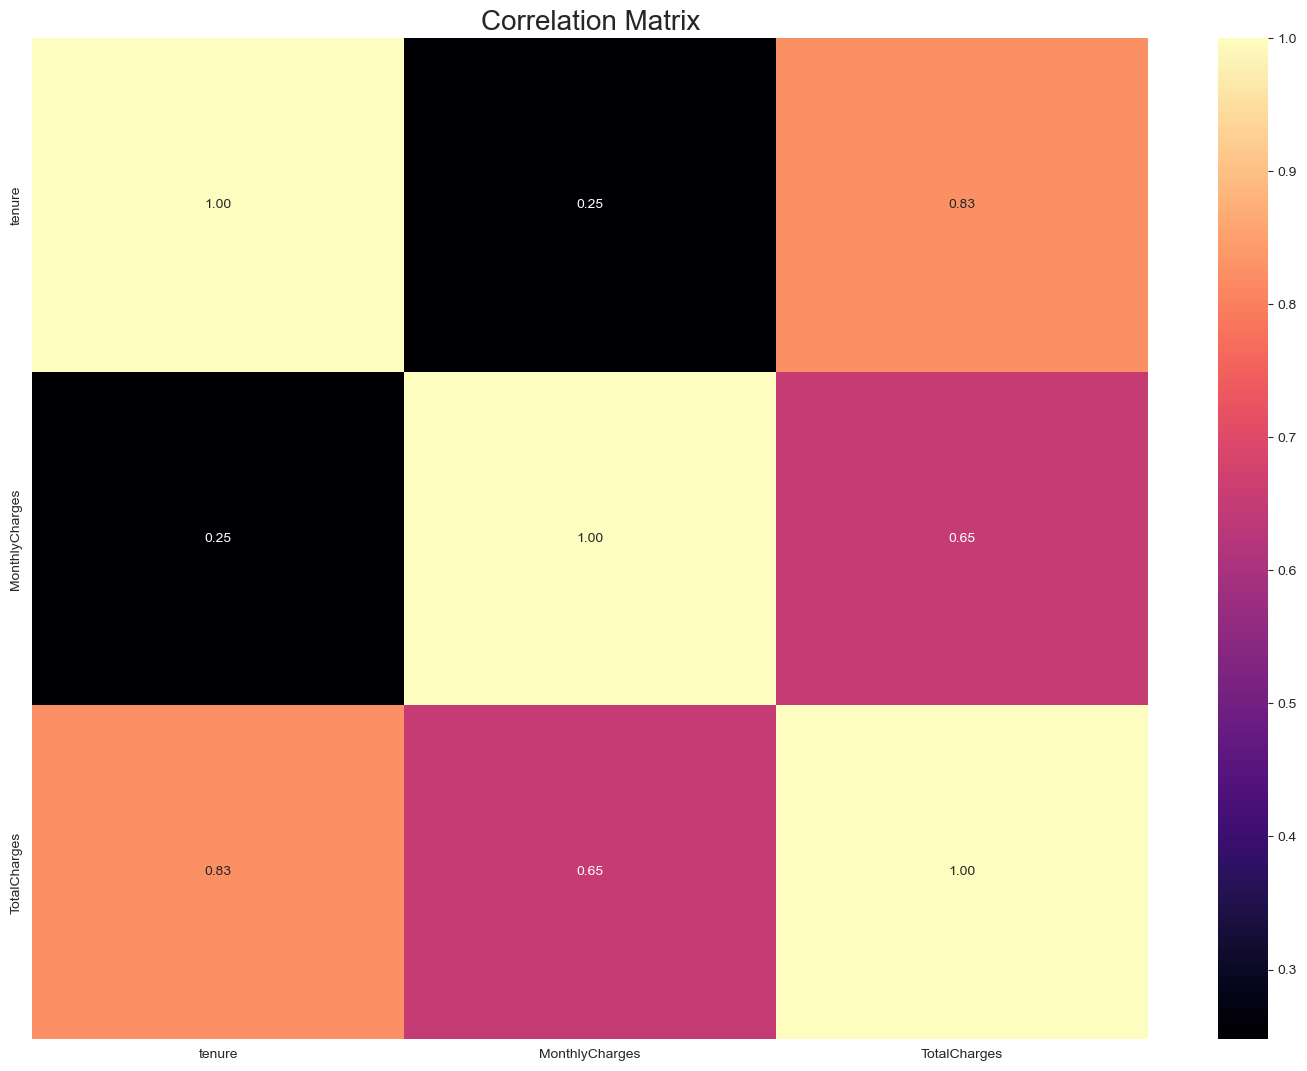

In [54]:
# Calculate and plot the correlation matrix for numerical features
correlation_matrix = df[num_cols].corr()
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [55]:
# Function to determine outlier thresholds
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Function to check for outliers
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# Check for outliers in numerical columns
check_outlier(df, num_cols)

False

In [56]:
# Check for missing values
df.isnull().any()
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [57]:
# Function to create a missing values table
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

# Identify columns with missing values
na_columns = missing_values_table(df, na_name=True)

              n_miss  ratio
TotalCharges      11  0.160


In [58]:
# Split the dataset indices into training, validation, and test sets
indices = np.arange(len(df))
indices_train, indices_test = train_test_split(indices, test_size=0.2, random_state=0)
indices_train, indices_val = train_test_split(indices_train, test_size=0.2, random_state=0)

In [59]:
# Function to replace missing values with the mean from the training set
def replace_missing_values_by_mean(df, var, train_ind):
    var_train = df[var].iloc[train_ind]
    var_train_mean = np.mean(var_train)
    df[var].fillna(var_train_mean, inplace=True)

replace_missing_values_by_mean(df, "TotalCharges", indices_train)

In [60]:
# Check for missing values after replacement
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [61]:
# Function to standardize numerical columns
def standardize(df, var, train_ind):
    var_train = df[var].iloc[train_ind]
    var_train_mean = np.mean(var_train)
    var_train_std = np.std(var_train)
    df[var] = (df[var] - var_train_mean) / var_train_std
    return df[var]

In [62]:
# Feature engineering: create new features based on existing ones
# Create a new feature indicating tenure as years
df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

In [63]:
# Create a new feature indicating if a customer has no protection plans
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

In [64]:
# Create a new feature for customer engagement based on contract length
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

In [65]:
# Create a new feature for automatic payment method
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)", "Credit card (automatic)"] else 0)

In [66]:
# Create a new feature indicating the total number of services subscribed
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

In [67]:
# Create a new feature indicating if the customer uses any streaming service
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

In [68]:
# Create a new feature indicating if a young customer is not engaged
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

In [69]:
# Display the updated DataFrame
print(df.head())
print(df.shape)

   gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines  \
0  Female              0     Yes         No       1           No  No phone service   
1    Male              0      No         No      34          Yes                No   
2    Male              0      No         No       2          Yes                No   
3    Male              0      No         No      45           No  No phone service   
4  Female              0      No         No       2          Yes                No   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0             DSL             No          Yes               No          No          No   
1             DSL            Yes           No              Yes          No          No   
2             DSL            Yes          Yes               No          No          No   
3             DSL            Yes           No              Yes         Yes          No   
4     Fiber optic             No 

In [70]:
# Recalculate column names after feature engineering
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 27
cat_cols: 24
num_cols: 3
cat_but_car: 0
num_but_cat: 8


In [71]:
# Function to encode binary categorical columns using label encoding
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [72]:
# Identify binary categorical columns
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
print(binary_cols)

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']


In [73]:
# Apply label encoding to binary columns
for col in binary_cols:
    df = label_encoder(df, col)

In [74]:
# Update categorical column list to exclude binary columns
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
print(cat_cols)

['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'NEW_TENURE_YEAR', 'SeniorCitizen', 'NEW_noProt', 'NEW_Engaged', 'NEW_FLAG_AutoPayment', 'NEW_FLAG_ANY_STREAMING', 'NEW_Young_Not_Engaged']


In [75]:
# Function to perform one-hot encoding on categorical columns
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

# Apply one-hot encoding to the categorical columns
df = one_hot_encoder(df, cat_cols, drop_first=True)

# Display the DataFrame after one-hot encoding
df.head()

,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_noProt_1,NEW_Engaged_1,NEW_FLAG_AutoPayment_1,NEW_FLAG_ANY_STREAMING_1,NEW_Young_Not_Engaged_1
0,0,1,0,1,0,1,29.850,29.850,0,1,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True
1,1,0,0,34,1,0,56.950,1889.500,0,3,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,True,False,False,False
2,1,0,0,2,1,1,53.850,108.150,1,3,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True
3,1,0,0,45,0,0,42.300,1840.750,0,3,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,True,True,False,False
4,0,0,0,2,1,1,70.700,151.650,1,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True


In [76]:
# Standardize numerical columns
for col in num_cols:
    standardize(df, col, indices_train)

In [77]:
# Prepare features (X) and target variable (y)
X = df.drop("Churn", axis=1)  
y = df["Churn"]

# Split data into training, validation, and test sets
X_train, y_train = X.iloc[indices_train], y.iloc[indices_train]
X_val, y_val = X.iloc[indices_val], y.iloc[indices_val]
X_test, y_test = X.iloc[indices_test], y.iloc[indices_test]

In [78]:
# Convert DataFrames to NumPy arrays for modeling
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

In [79]:
# Define and evaluate multiple classification models
models = [('LR', LogisticRegression(max_iter=1000)),
          ('KNN', KNeighborsClassifier()),
          ("CART", DecisionTreeClassifier()),
          ("RF", RandomForestClassifier()),
          ('Adaboost', AdaBoostClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
          ('CatBoost', CatBoostClassifier(verbose=False))]

# Evaluate each model on the validation set
for name, model in models:
    print(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
        if score == "roc_auc":
            score_value = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
        elif score == "f1":
            score_value = f1_score(y_val, y_pred)
        elif score == "precision":
            score_value = precision_score(y_val, y_pred, zero_division=0)
        elif score == "recall":
            score_value = recall_score(y_val, y_pred)
        else:  # accuracy
            score_value = accuracy_score(y_val, y_pred)
        print(f"{score} score: {score_value:.4f}")
    print("\n")

LR
roc_auc score: 0.8564
f1 score: 0.5918
precision score: 0.6667
recall score: 0.5320
accuracy score: 0.8066


KNN
roc_auc score: 0.7860
f1 score: 0.5477
precision score: 0.5762
recall score: 0.5219
accuracy score: 0.7728


CART
roc_auc score: 0.6818
f1 score: 0.5307
precision score: 0.5109
recall score: 0.5522
accuracy score: 0.7427


RF
roc_auc score: 0.8362
f1 score: 0.5476
precision score: 0.6468
recall score: 0.4747
accuracy score: 0.7933


Adaboost
roc_auc score: 0.8544
f1 score: 0.5779
precision score: 0.6638
recall score: 0.5118
accuracy score: 0.8030


GBM
roc_auc score: 0.8564
f1 score: 0.5720
precision score: 0.6537
recall score: 0.5084
accuracy score: 0.7995


XGBoost
roc_auc score: 0.8350
f1 score: 0.5602
precision score: 0.6340
recall score: 0.5017
accuracy score: 0.7924


CatBoost
roc_auc score: 0.8530
f1 score: 0.5671
precision score: 0.6466
recall score: 0.5051
accuracy score: 0.7968


In [80]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],                # Type of regularization
    'solver': ['liblinear', 'saga']        # Optimization algorithms
}

# Initialize Logistic Regression model
lr = LogisticRegression(max_iter=1000)

# Set up Grid Search for hyperparameter tuning
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

# Fit Grid Search to find the best model
grid_search.fit(X_train, y_train)

# Retrieve and print the best model
best_lr = grid_search.best_estimator_
print(best_lr)

LogisticRegression(C=10, max_iter=1000, penalty='l1', solver='saga')


In [81]:
# Train the final Logistic Regression model with the best parameters
logisticreg = LogisticRegression(
    C=10,  
    max_iter=1000,                
    penalty='l1',
    solver='saga'
)

logisticreg.fit(X_train, y_train)

# Predict labels and probabilities on the test set
y_test_pred = logisticreg.predict(X_test)
y_test_proba = logisticreg.predict_proba(X_test)[:, 1]

# Print evaluation metrics for the test set
print("Test Set:")
print(f"ROC AUC score: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"F1 score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision score: {precision_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"Recall score: {recall_score(y_test, y_test_pred):.4f}")

Test Set:
ROC AUC score: 0.8285
F1 score: 0.5671
Precision score: 0.6458
Recall score: 0.5054


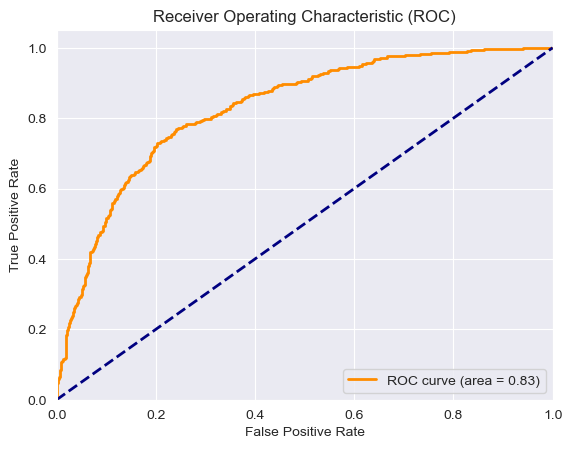

In [82]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

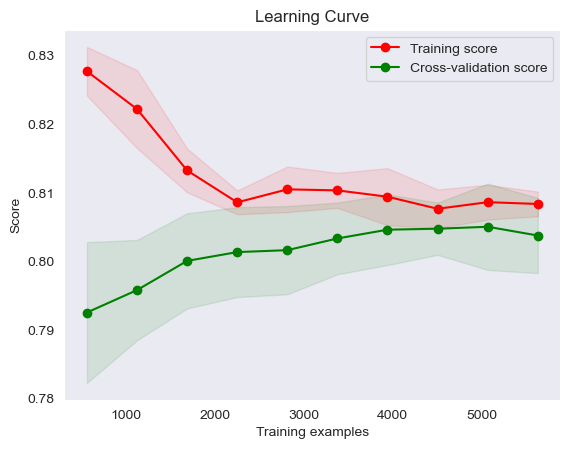

In [83]:
# Compute learning curve data for the Logistic Regression model
train_sizes, train_scores, validation_scores = learning_curve(
    logisticreg,
    X,
    y,
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate mean and standard deviation of training and validation scores
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_mean = validation_scores.mean(axis=1)
validation_scores_std = validation_scores.std(axis=1)

# Plot learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()